# MIE1624 - Assignment 1
*By Andrés De los Ríos -  26/02/2019*

## Table of Contents
1. [Prerequisites](#1)
2. [Data Cleaning](#2)
3. [Exploratory Analysis](#3)
4. [Model Preparation](#4)
5. [Model Implementation](#5)
6. [Results & Discussion](#6)

## 1. Prerequisites <a name="1"></a>

### Libraries

In [1480]:
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, accuracy_score 
from sklearn import preprocessing
from nltk.corpus import stopwords 
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from yellowbrick.text import FreqDistVisualizer

### Constants

In [1232]:
#Arbitrary negative reason categories to decrease the classes used in the multi-class logistic regression model
reason_categories = {"Flight Problems":['Bad Flight','Late Flight', 'Cancelled Flight'], 
                      "Luggage Problems": ['Damaged Luggage', 'Lost Luggage'], 
                     "Customer Attention Problems": ['longlines','Flight Attendant Complaints', "Flight Booking Problems", 'Customer Service Issue'],
                    "Unknown": ["Can't Tell"]}

#Populated by a_Count function to count all @-mentions in the tweets - primary and secondary.
#Note: primary mentions are those that come first in the tweet; they are considered the tweet's main addressee
air = {}

#Populated by h_Count function to count all hashtags in the tweets
hasht = {}

In [1233]:
#Most popular airlines in the dataset; derived from the count of @-mentions in Fig. 1
airlines = ['virginamerica', 'united', 'southwestair', 'jetblue', 'usairways', 'americanair']

#List of colors used for Fig. 16
colors = ['seagreen', 'indianred', 'steelblue', 'darkmagenta', 'wheat',
           'orange', 'mediumslateblue',
           'crimson', 'darkkhaki']

In [1481]:
#Regex pattern to remove free-standing URL symbols as well as isolated @-signs. 
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|,;]|( @ )')

#Regex pattern to remove numbers and accented letters (but not @-signs or hashtags) from within words.
BAD_SYMBOLS_RE = re.compile('[^a-z #+_@]')

#Set of stopwords provided by NLTK
STOPWORDS = set(stopwords.words('english'))

#Regex pattern to remove tweet handles once they have been extracted from the text
TWEET_HANDLE = re.compile('@([A-Za-z0-9_]+)')

#Regex pattern to remove hashtags once they have been extracted from the text
HASHTAG = re.compile('#')

#Extra stopwords to update the set; determined by the distribution of the Top 50 tokens (Fig. 5)
extra_stopwords = ["flight", "plane", "gate", "really", "get", "hour", "aa", "ua", "southwest", "one", "sw", "customer", "service"]


### Functions

In [1235]:
def clean_Text(text):
    """
    text: a string
    
    return: modfied string with no accented characters - except @-symbols and hashtags. 
    
    """
    text = text.lower()
    
    text = re.sub(r'https?://\S+','', text)
    
    text = html.unescape(text)
    
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    
    text = BAD_SYMBOLS_RE.sub(' ', text)
    
    text = ' '.join(word for word in text.split() if word not in STOPWORDS).strip(" ")

    return text

In [1482]:
def clean_Text_2(text):
    
    """
    text: a string
    
    return: modified string with no Twitter handles to process through the model
    
    """
    
    text = TWEET_HANDLE.sub(' ', text)
    
    text = HASHTAG.sub('', text)
    
    text = ' '.join(word for word in text.split() if word not in STOPWORDS).strip(" ")

    return text

In [1237]:
def summarize_Reasons(reason):
    """
    reason: a string (in the dataframe's "negative_reason" feature)
    
    return: a string of the summary category to which the negative reason belongs
    
    """
    for cat in reason_categories.keys():
        
        if reason in reason_categories[cat]:
            
            return cat

In [1238]:
def a_Count(a_list):
    """
    a_list: list of airlines (in the dataframe's "airlines" feature)
    
    return: none
    
    Note: function populates pre-existing, empty dictionary instance "air"
    """

    for a in a_list:
        if a in air:
            air[a] += 1
        
        else:
            air[a] = 1

In [1239]:
def h_Count(h_list):
    """
    h_list: list of hashtags (in the dataframe's "hashtag" feature)
    
    return: none
    
    Note: function populates pre-existing, empty dictionary instance "hasht"
    """
    if len(h_list) > 0:
        for a in h_list:
            if a in hasht:
                hasht[a] += 1

            else:
                hasht[a] = 1

In [1240]:
def get_Sentiment_Sum(airline_list):
    """
    airline_list: list of the dataset's 6 main airlines. 
    
    return: two lists with the positive (pos) and negative (neg) tweets 
    for each of the dataset's 6 main airlines. 
    """
    pos = []
    neg = []
    for a in airline_list:
        pos.append(len(df_main[(df_main["sentiment"] == "positive") & (df_main["main_airline"] == a)]))
        neg.append(len(df_main[(df_main["sentiment"] == "negative") & (df_main["main_airline"] == a)]))
        
    return pos, neg

In [1241]:
def autolabel(rects):
    """
    rects: plt.bar plot. 
    return: none
    
    Note: function attaches a text label above each bar displaying its height/value.
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.015*height,
                str(round(height, 4)),
                ha='center', va='bottom')

In [1242]:
def get_Sentiment_Ratio(airline_list, pos, neg):
    """
    airline_list: list of the dataset's 6 main airlines. 
    pos: list with the count of positive tweets per airline. 
    neg: list with the count of negative tweets per airline. 
    
    return: list with the positive-to-negative tweet ratio per airline.
    """
    
    ratios = []
    
    for i in range(len(airline_list)):

        ratios.append(pos[i]/neg[i])
    
    return ratios

In [1301]:
def create_Wordclouds(airline_list, stopwords_update):
    """
    airline_list: list of the dataset's 6 main airlines. 
    stopwords_update: list of stopwords to add after analysis of the dataset's common tokens
    
    return: none
    
    Note: function displays one word cloud for each airline's corpus of tweet text 
    """
    
    stopwords = set(STOPWORDS)
    stopwords.update(stopwords_update, airlines)
    
    for a in airline_list:
        
        a_text = " ".join(tweet for tweet in df_main[df_main["main_airline"] == a].clean_text)
        
        a_wordcloud = WordCloud(background_color="white", max_words=50, stopwords=stopwords).generate(a_text)
        
        plt.imshow(a_wordcloud, interpolation='bilinear')
        plt.title(a, size = 40)
        plt.axis("off")
        plt.show()

In [1244]:
def get_Word_Counts(airline_list):
    """
    airline_list: list of the dataset's 6 main airlines. 
    
    counts: list each airline's total word count across its tweet corpus.
    """
    counts = []
    for a in airline_list:
        count = df_main[df_main['main_airline'] == a]["clean_text"].apply(lambda x: len(x.split(' '))).sum()
        counts.append(count)
        
    return counts

In [1245]:
def get_Negative_Reasons(airline_list, reasons_list):
    """
    airline_list: list of the dataset's 6 main airlines.
    reasons_list: list of the negative reasons to be considered for analysis
    
    
    total_reason_counts: list of lists displaying each airline's total number of tweets within
    each negative reason category
    """
    
    total_reasons_count = []
    
    for r in reasons_list:
        
        count = []
                
        for a in airline_list:
            
            count.append(len(df_main[(df_main["negative_reason"] == r) & (df_main["main_airline"] == a)]))
            
        total_reasons_count.append(count)
            
    return total_reasons_count

## 2. Data Cleaning <a name="2"></a>

### Text Extraction & Cleaning

In [ ]:
#Open airline data file with Latin encoding
df_air = pd.read_csv("US_airline_tweets.csv", encoding = "ISO-8859-1")

In [1247]:
#Extract generic tweet data from txt file
gen_t = open('generic_tweets.txt','r').read()

gen_t_list = gen_t.split('\n')

gen_t_cols = gen_t_list[0].split(",")

#Delete header and blank data at the beginning and end of the file
del gen_t_list[0]
del gen_t_list[-1]

In [1248]:
#Extract the features of each tweet record for dataframe transformation
sentiments = [tw.split(',')[0].strip('"') for tw in gen_t_list]
t_id = [tw.split(',')[1].strip('"') for tw in gen_t_list]
date = [tw.split(',')[2].strip('"') for tw in gen_t_list]
query = [tw.split(',')[3].strip('"') for tw in gen_t_list]
user = [tw.split(',')[4].strip('"') for tw in gen_t_list]
text = ["".join(tw.split(',')[5:]).strip('"') for tw in gen_t_list]

In [1249]:
#Transform generic tweet data into dataframe
df_gen = pd.DataFrame({
        'sentiment': sentiments,
        'date': date,
        'query': query,
        'user': user,
        'text': text
                    }, index = t_id)

### Dataframe Set-Up

In [1250]:
#Remove punctuation, URL characters and punctuation from tweet data - but leave # and @-handles
df_gen["clean_text"] = df_gen["text"].apply(clean_Text)
df_air["clean_text"] = df_air["text"].apply(clean_Text)

In [1252]:
df_gen.clean_text.head()

1467810369    @switchfoot awww bummer shoulda got david carr...
1467810672    upset update facebook texting might cry result...
1467810917    @kenichan dived many times ball managed save r...
1467811184                     whole body feels itchy like fire
1467811193                    @nationwideclass behaving mad see
Name: clean_text, dtype: object

In [1253]:
df_air.clean_text.head()

0    @virginamerica plus added commercials experien...
1    @virginamerica really aggressive blast obnoxio...
2                  @virginamerica really big bad thing
3    @virginamerica seriously would pay flight seat...
4    @virginamerica yes nearly every time fly vx ea...
Name: clean_text, dtype: object

In [1254]:
#Extract @-handles and hashtags from text for analysis
df_air["airlines"] = df_air["clean_text"].apply(lambda x: re.findall(r'@([A-Za-z0-9_]+)', x))
df_air["hashtags"] = df_air["clean_text"].apply(lambda x: re.findall(r'#([A-Za-z0-9_]+)', x))

In [1256]:
df_air.airlines.head()

0    [virginamerica]
1    [virginamerica]
2    [virginamerica]
3    [virginamerica]
4    [virginamerica]
Name: airlines, dtype: object

In [1261]:
df_air[df_air["hashtags"].apply(lambda x: len(x)) > 3].hashtags.head()

22       [vx, noair, worstflightever, roasted, sfotobos]
89                   [oscars, redcarpet, oscars, oscars]
99     [flight, dc, sunset, globe, backtowinter, work...
706    [terrible, branson, virginatlantic, unitedairl...
834         [linesforever, customerservice, fail, again]
Name: hashtags, dtype: object

In [1262]:
#Extract word length of each tweet for analysis
df_air["text_length"] = df_air["text"].apply(lambda x: len(x.split(" ")))
df_gen["text_length"] = df_gen["text"].apply(lambda x: len(x.split(" ")))

In [1268]:
df_gen[["text","text_length"]].head()

,text,text_length
1467810369,@switchfoot http://twitpic.com/2y1zl - Awww th...,20
1467810672,is upset that he can't update his Facebook by ...,22
1467810917,@Kenichan I dived many times for the ball. Man...,19
1467811184,my whole body feels itchy and like its on fire,11
1467811193,@nationwideclass no it's not behaving at all. ...,22


In [1269]:
df_air[["text","text_length"]].head()

,text,text_length
0,@VirginAmerica plus you've added commercials t...,9
1,@VirginAmerica it's really aggressive to blast...,17
2,@VirginAmerica and it's a really big bad thing...,10
3,@VirginAmerica seriously would pay $30 a fligh...,22
4,"@VirginAmerica yes, nearly every time I fly VX...",15


In [1270]:
#Categorize airline data sentiment label to generic tweet data sentiment label
#Facilitates future logistic regression model implementation
df_air["sentiment_n"] = df_air["sentiment"].apply(lambda x: "0" if x == "negative" else "4")

In [1272]:
df_air[["sentiment","sentiment_n"]].head()

,sentiment,sentiment_n
0,positive,4
1,negative,0
2,negative,0
3,negative,0
4,positive,4


In [1273]:
#Summarize negative reasons into fewer categories
#Increases accuracy of multi-class logistic regression model by decreasing the number of potential labels
df_air["reason_category"] = df_air["negative_reason"].apply(summarize_Reasons)

In [1274]:
df_air[["negative_reason","reason_category"]].head()

,negative_reason,reason_category
0,NaN,None
1,Bad Flight,Flight Problems
2,Can't Tell,Unknown
3,Can't Tell,Unknown
4,NaN,None


## 3. Exploratory Analysis <a name="3"></a>

### Airline Tweets - Notable @-Mentions

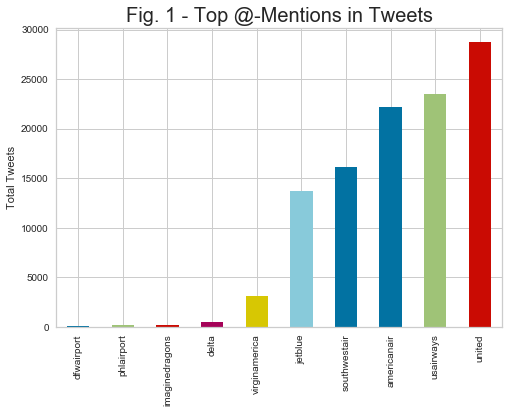

In [1336]:
#Count total mentions of airlines - primary and secondary - across the dataset
#Create series and its visual from which we can derive the 6 most popular airlines addressed by twitter users
#Top 6 Airlines: United, USAirways, AmericanAir, Southwest, Jetblue, VirginAmerica, Delta

df_air["airlines"].apply(a_Count)
s_airlines = pd.Series(air)

plt.title("Fig. 1 - Top @-Mentions in Tweets", size = 20)
plt.ylabel("Total Tweets")
s_airlines.sort_values()[-10:].plot.bar()

In [1285]:
s_airlines[["united", "usairways", "americanair", "southwestair", "jetblue", "virginamerica"]]

united           25536
usairways        20856
americanair      19696
southwestair     14304
jetblue          12152
virginamerica     2752
dtype: int64

### Airline Tweets - Notable Hashtags

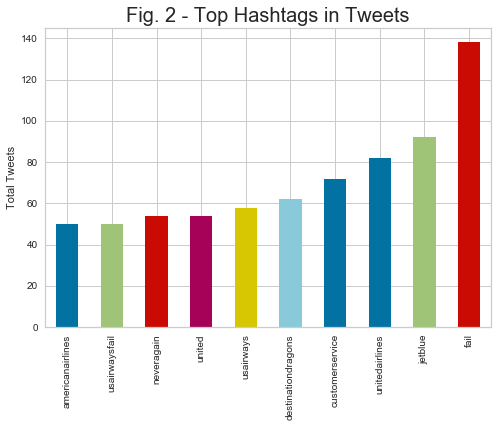

In [1337]:
#Count total hashtags across the dataset
#Create series and its visual from which we can derive the most popular hashtags used by users

df_air["hashtags"].apply(h_count)

s_hashtags = pd.Series(hasht)

plt.title("Fig. 2 - Top Hashtags in Tweets", size = 20)
plt.ylabel("Total Tweets")
s_hashtags.sort_values()[-10:].plot.bar()

In [1287]:
s_hashtags[["fail", "jetblue", "unitedairlines", 
            "customerservice", "destinationdragons", "usairways",
            "united", "neveragain", "usairwaysfail", "americanairlines"]]

fail                  69
jetblue               46
unitedairlines        41
customerservice       36
destinationdragons    31
usairways             29
united                27
neveragain            27
usairwaysfail         25
americanairlines      25
dtype: int64

### Airline Tweets - Determining Main Airline per Tweet

In [1288]:
#Get primary airline of each tweet - i.e. the first @-handle showing the account to which the tweet is addressed
df_air["main_airline"] = df_air["airlines"].apply(lambda x: x[0])

In [1290]:
#Determine airline-related @-handles:
#These are Virgin America, United, Southwest, Jetblue, USAirways, American Airlines, Delta
#Note: Delta and Spirit were not considered due to small number of records - 60 and 8, respectively
df_air.main_airline.unique()

array(['virginamerica', 'united', 'lindaswc', 'southwestair',
       'melissaafrancis', 'dadboner', 'imaginedragons', 'kciairport',
       'jetblue', 'eatgregeat', 'nytimes', 'ninadavuluri', 'usairways',
       'sb', 'timbennettg', 'nrhodes', 'sarahpompei', 'andrewfallis',
       'scm', 'americanair', 'deltaassist', 'djevolutionhd', 'malhoit',
       'vanessaannz'], dtype=object)

In [1291]:
#Create a dataframe with records whose main airline is one of the six most popular airlines. 

df_main = df_air[df_air["main_airline"].isin(airlines)]

In [1293]:
df_main.head()

,id,sentiment,negative_reason,user,retweet_count,text,clean_text,airlines,hashtags,text_length,sentiment_n,reason_category,main_airline
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...,@virginamerica plus added commercials experien...,[virginamerica],[],9,4,None,virginamerica
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...,@virginamerica really aggressive blast obnoxio...,[virginamerica],[],17,0,Flight Problems,virginamerica
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...,@virginamerica really big bad thing,[virginamerica],[],10,0,Unknown,virginamerica
3,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...,@virginamerica seriously would pay flight seat...,[virginamerica],[],22,0,Unknown,virginamerica
4,5.703010e+17,positive,NaN,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX...",@virginamerica yes nearly every time fly vx ea...,[virginamerica],[],15,4,None,virginamerica


### Airline Tweets - Positive vs Negative Tweets by Main Airline

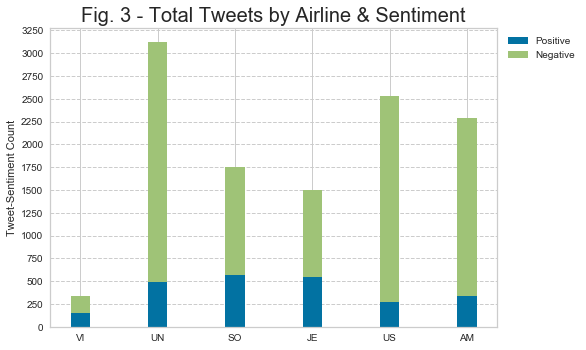

In [1338]:
#Total Pos/Neg tweets by company (only top-6) according to original dataset
A_pos, A_neg = get_Sentiment_Sum(airlines)

N = 6
ind = np.arange(N)
width = 0.25
p1 = plt.bar(ind, A_pos, width)
p2 = plt.bar(ind, A_neg, width, bottom = A_pos)

plt.ylabel("Tweet-Sentiment Count")
plt.title("Fig. 3 - Total Tweets by Airline & Sentiment", size = 20)
plt.xticks(ind, map(lambda x: x[:2].upper(), airlines))
plt.yticks(np.arange(0, 3500, step=250))
plt.legend(["Positive", "Negative"], loc=9, bbox_to_anchor=(1.1, 1))
plt.grid(True, linestyle='--', axis='y')
plt.show()

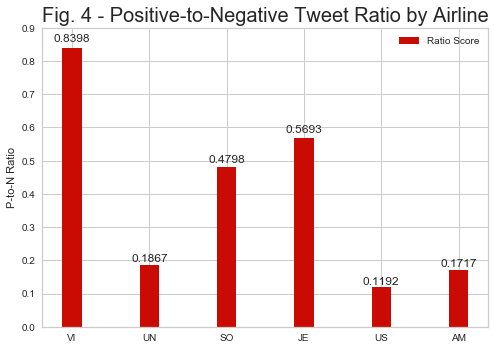

In [1339]:
#Ratio of Pos to Neg tweets by company (only top-6) according to original dataset

A_rat = get_Sentiment_Ratio(airlines, A_pos, A_neg)

fig, ax = plt.subplots()
rects1 = ax.bar(ind, A_rat, width, color='r')

plt.ylabel("P-to-N Ratio")
plt.title("Fig. 4 - Positive-to-Negative Tweet Ratio by Airline", size = 20)
plt.xticks(ind, map(lambda x: x[:2].upper(), airlines))
plt.yticks(np.arange(0, 1, step=0.10))
plt.legend(["Ratio Score"])


autolabel(rects1)

plt.show()

### Airline Tweets - Notable Vocabulary by Airline (BONUS)

In [1296]:
#Remove handles to keep airline names from word clouds

df_main["clean_text"] = df_main["clean_text"].apply(clean_Text_2)

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [1297]:
df_main.clean_text.head()

0              plus added commercials experience tacky
1    really aggressive blast obnoxious entertainmen...
2                                 really big bad thing
3    seriously would pay flight seats playing reall...
4        yes nearly every time fly vx ear worm go away
Name: clean_text, dtype: object

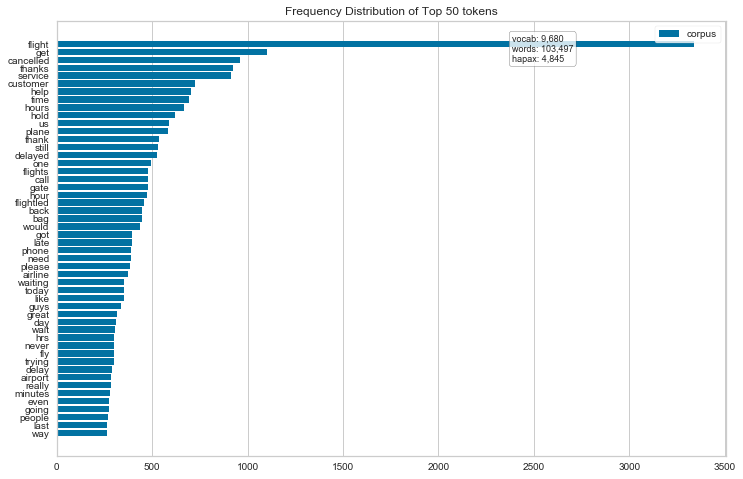

Fig. 5


In [1343]:
#Find most common tokens to know how to update the stoplist
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(df_main['clean_text'])
features   = vectorizer.get_feature_names()
plt.figure(figsize=(12,8))
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
for label in visualizer.ax.texts:
    label.set_size(20)
visualizer.poof()
print("Fig. 5")

<div style="text-align: center"><font size="+1"><b>Figs. 6 - 11</b></font></div>

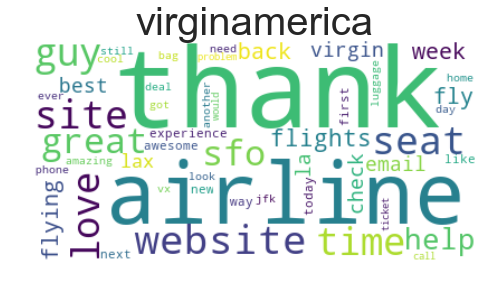

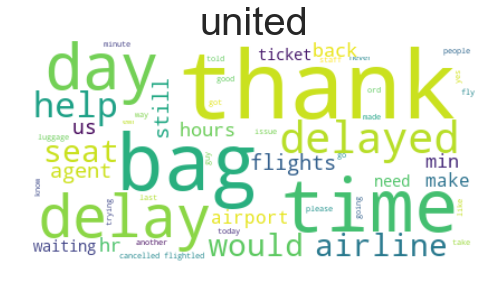

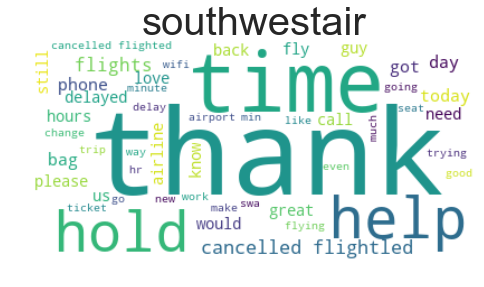

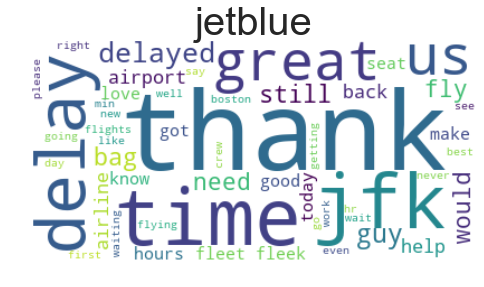

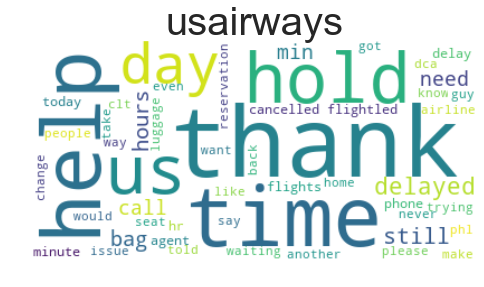

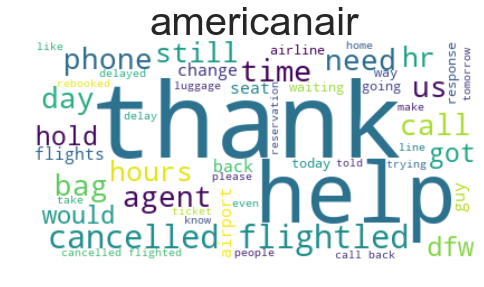

In [1459]:
create_Wordclouds(airlines, extra_stopwords)

### Generic Tweets - Notable Vocabulary by Sentiment (BONUS)

In [1303]:
#Word Cloud per Sentiment in Generic Tweet
df_gen["clean_text"] = df_gen["clean_text"].apply(clean_Text_2)

<div style="text-align: center"><font size="+1"><b>Figs. 12 - 13</b></font></div>

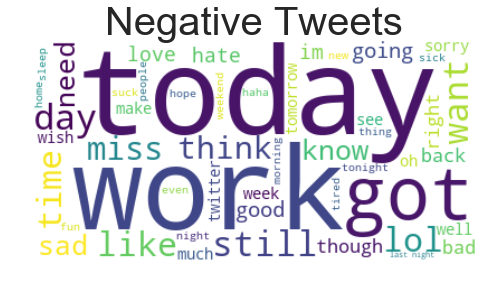

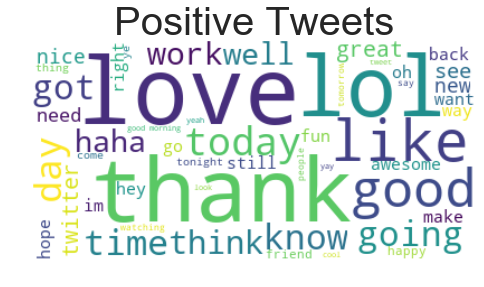

In [1308]:
stoplist = set(STOPWORDS)
stoplist.update(extra_stopwords)

for s in df_gen.sentiment.unique():
    
    s_text = " ".join(tweet for tweet in df_gen[df_gen["sentiment"] == s].clean_text)
    
    s_wordcloud = WordCloud(background_color="white", max_words=50, stopwords=stoplist).generate(s_text)

    plt.imshow(s_wordcloud, interpolation='bilinear')
    plt.title("Negative Tweets" if s == '0' else "Positive Tweets", size=40)
    plt.axis("off")
    plt.show()

### Airline Tweets - Total of Words in Tweets by Airline

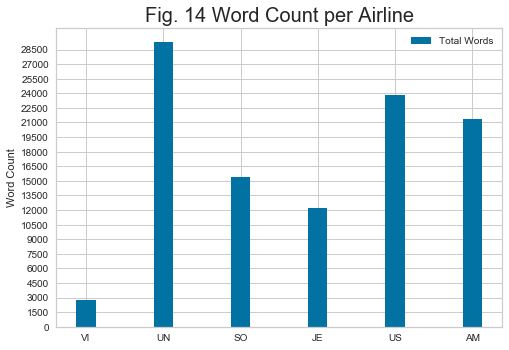

In [1453]:
#Obtain and display total number of words per Airline

A_count = get_Word_Counts(airlines)


p3 = plt.bar(ind, A_count, width)

plt.ylabel("Word Count")
plt.title("Fig. 14 Word Count per Airline", size = 20)
plt.xticks(ind, map(lambda x: x[:2].upper(), airlines))
plt.yticks(np.arange(0, 30000, step=1500))
plt.legend(["Total Words"])


autolabel(rects1)

plt.show()


### Airline Tweets - Avgerage Words per Tweet by Airline

In [1310]:
#Obtain and display average number of words per tweet per airline
A_tweets_n = [df_main[df_main["main_airline"] == a].shape[0] for a in airlines]
A_avgs = [A_count[i]/A_tweets_n[i] for i in range(len(airlines))]

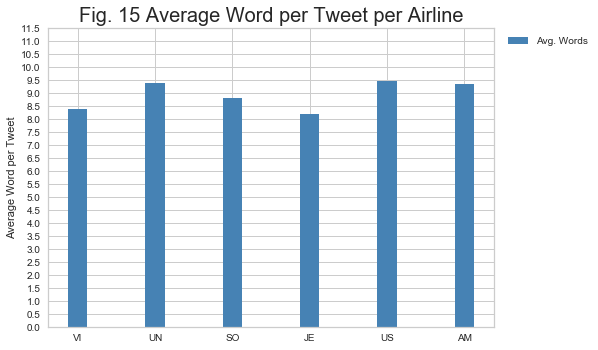

In [1454]:
p4 = plt.bar(ind, A_avgs, width, color = "steelblue")

plt.ylabel("Average Word per Tweet")
plt.title("Fig. 15 Average Word per Tweet per Airline", size=20)
plt.xticks(ind, map(lambda x: x[:2].upper(), airlines))
plt.yticks(np.arange(0, 12, step=0.5))
plt.legend(["Avg. Words"], loc=9, bbox_to_anchor=(1.12, 1))


autolabel(rects1)

plt.show()

### Airline Tweets - Total Negative Reasons by Airline

,virginamerica,united,southwestair,jetblue,usairways,americanair
longlines,3,48,29,13,49,34
Damaged Luggage,4,22,14,11,11,12
Cancelled Flight,18,181,162,51,188,246
Flight Attendant Complaints,5,168,38,60,123,87
Lost Luggage,5,268,90,57,154,149
Flight Booking Problems,28,143,62,44,122,129
Customer Service Issue,60,680,391,199,808,766
Late Flight,17,525,152,269,452,249
Bad Flight,19,216,90,64,104,87


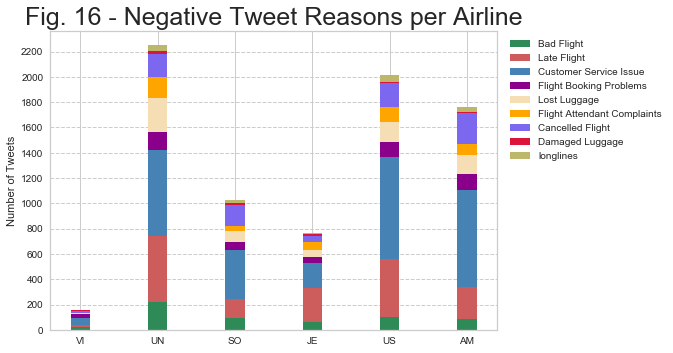

In [1455]:
#Removed NaN and "Can't Tell" to Focus on Clear Issues
reasons = [r for r in df_main.negative_reason.unique() if r not in [np.nan, "Can't Tell"]]

A_reasons = get_Negative_Reasons(airlines, reasons)

rectsZ = plt.bar(ind, A_reasons[0][:],width, color=colors[0])

bottom_height = [0.] * len(A_reasons[0][:])

for i in range(1,9):
    bottom_height = [bottom_height[j] + A_reasons[i-1][j] for j in range(len(bottom_height))]

    rectsZ = plt.bar(ind, A_reasons[i][:],width,
     color=colors[i],
     bottom=bottom_height)


plt.ylabel("Number of Tweets")
plt.title("Fig. 16 - Negative Tweet Reasons per Airline",size = 25)
plt.xticks(ind, map(lambda x: x[:2].upper(), airlines))
plt.yticks(np.arange(0, 2400, step=200))
plt.legend(reasons, loc=9, bbox_to_anchor=(1.2, 1))
plt.grid(True, linestyle='--', axis='y')

#Show table with tallies for easier interpretation
df_reasons = pd.DataFrame(A_reasons, columns= airlines, index = reasons)
df_reasons.iloc[::-1]

#Main issues seem to be "Late Flight", "Customer Service Issue", and "Cancelled Flight"

### Airline Tweets - Customer Service Wordcloud

<div style="text-align: center"><font size="+1"><b>Fig. 17</b></font></div>

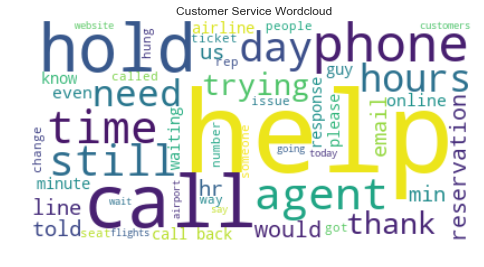

In [1316]:
#Extract word cloude of "Customer Service Issue" reason for further analysis of causes for complaints
stopwords = set(STOPWORDS)
stopwords.update(extra_stopwords, airlines)
    
c_text = " ".join(tweet for tweet in df_main[df_main["negative_reason"] == "Customer Service Issue"].clean_text)
        
c_wordcloud = WordCloud(background_color="white", max_words=50, stopwords=stopwords).generate(c_text)

plt.imshow(c_wordcloud, interpolation='bilinear')
plt.title("Customer Service Wordcloud")
plt.axis("off")
plt.show()

#Shows words related to being held in the call-line

### Airline Tweets - Boxplot of Tweet Word Length by Airline

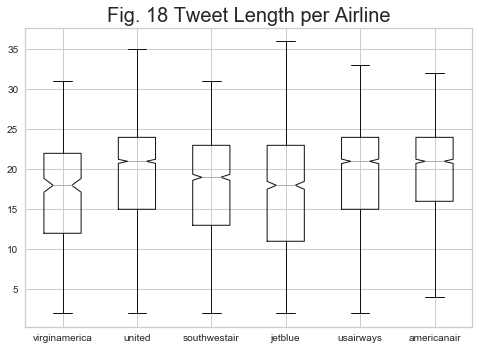

In [1457]:
#Boxplots of Tweet Word Length
A_length = [df_main[df_main["main_airline"] == a]["text_length"] for a in airlines ]
p123  = plt.boxplot(A_length, 1, labels=airlines)
plt.title("Fig. 18 Tweet Length per Airline", size = 20)
plt.show()

## 4. Model Preparation <a name="4"></a>

### Generic Tweets - Split Datasets

In [1318]:
##Split Datasets - Generic
gen_X_train, gen_X_test, gen_y_train, gen_y_test = train_test_split(df_gen.clean_text.values, df_gen.sentiment.values,
                                                   stratify=df_gen.sentiment.values, 
                                                   random_state=42, test_size=0.3)

### Generic Tweets - Transform to Tf-idf Features

In [1319]:
#Words to TF-IDF Features - Generic
tfidf = TfidfVectorizer(strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=True,smooth_idf=True,sublinear_tf=True,
            stop_words = 'english')

tfidf.fit_transform(list(gen_X_train) + list(gen_X_test))
gen_X_train_tfidf =  tfidf.transform(gen_X_train) 
gen_X_test_tfidf = tfidf.transform(gen_X_test)

### Airline Tweets - Transform to Tf-idf Features

In [1483]:
#Words to TF-IDF Features - Airlines
df_air["clean_text"] = df_air["clean_text"].apply(clean_Text_2)
air_test_tfidf = tfidf.transform(df_air.clean_text.values)

### Negative Airline Tweets - Split Datasets

In [1466]:
#Split Datasets - Airlines Negative
df_airN = df_air[df_air["sentiment_n"] == "0"]

airN_X_train, airN_X_test, airN_y_train, airN_y_test = train_test_split(df_airN.clean_text.values, 
                                                                        df_airN.reason_category.values,
                                                                        stratify=df_airN.reason_category.values, 
                                                                        random_state=42, test_size=0.3)

### Negative Airline Tweets - Transform to Tf-idf Features

In [1467]:
#Words to TF-IDF Features - Airlines Negative 
airN_tfidf = TfidfVectorizer(strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=True,smooth_idf=True,sublinear_tf=True,
            stop_words = 'english')

airN_tfidf.fit_transform(list(airN_X_train) + list(airN_X_test))
airN_X_train_tfidf =  airN_tfidf.transform(airN_X_train) 
airN_X_test_tfidf = airN_tfidf.transform(airN_X_test)

## 5. Model Implementation <a name="5"></a>

### Logistic Regression Model - Initialize

In [1484]:
#Initialize and Fit Model to Generic Tweet Data
logregclf = LogisticRegression()
logregclf.fit(gen_X_train_tfidf, gen_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Logistic Regression Model - Generic Tweets Sentiment Prediction

In [1485]:
#Predict Generic Tweets Sentiment Labels
gen_y_pred = logregclf.predict(gen_X_test_tfidf)

#Model Results - Report (Generic Tweets Sentiment)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(gen_y_test, gen_y_pred)))
print(classification_report(gen_y_test, gen_y_pred))

---Test Set Results---
Accuracy with logreg: 0.7620666666666667
             precision    recall  f1-score   support

          0       0.78      0.73      0.75     30000
          4       0.75      0.79      0.77     30000

avg / total       0.76      0.76      0.76     60000



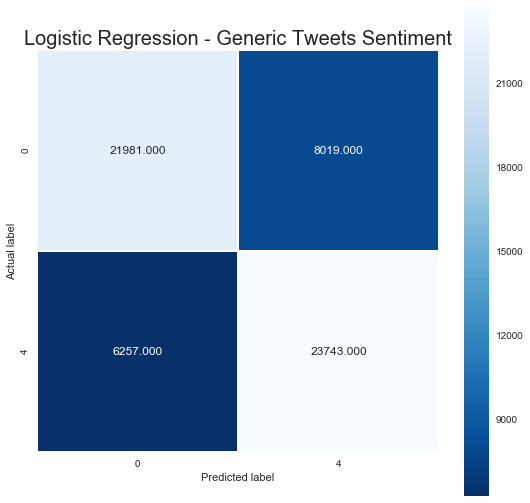

In [1486]:
#Model Results - Confusion Matrix (Generic Tweets Sentiment)
gen_cm = metrics.confusion_matrix(gen_y_test, gen_y_pred)
gen_score = accuracy_score(gen_y_test, gen_y_pred)

plt.figure(figsize=(9,9))
plt.xticks(np.arange(2), ["0", "4"])
plt.yticks(np.arange(2), ["0", "4"])
sns.heatmap(gen_cm, annot=True, fmt=".3f", linewidths=.5, 
            square = True, cmap = 'Blues_r', xticklabels= ["0", "4"], yticklabels=["0", "4"]);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = "Logistic Regression - Generic Tweets Sentiment"
plt.title(all_sample_title, size = 20);

### Logistic Regression Model - Airline Tweets Sentiment Prediction

In [1487]:
#Predict Airline Tweets Sentiment Labels
air_y_pred = logregclf.predict(air_test_tfidf)

#Model Results - Report (Generic Tweets Sentiment)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(df_air.sentiment_n.values, air_y_pred)))
print(classification_report(df_air.sentiment_n.values, air_y_pred))

---Test Set Results---
Accuracy with logreg: 0.7692574300320596
             precision    recall  f1-score   support

          0       0.96      0.74      0.84      9178
          4       0.47      0.87      0.61      2363

avg / total       0.86      0.77      0.79     11541



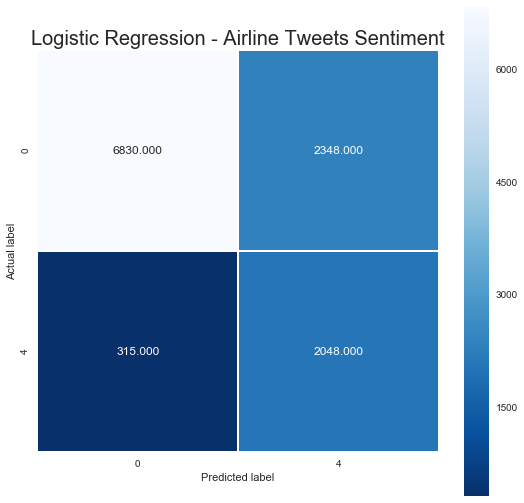

In [1488]:
#Model Results - Confusion Matrix (Airline Tweets Sentiment)
air_cm = metrics.confusion_matrix(df_air.sentiment_n.values, air_y_pred)
gen_score = accuracy_score(df_air.sentiment_n.values, air_y_pred)

plt.figure(figsize=(9,9))
plt.xticks(np.arange(2), ["0", "4"])
plt.yticks(np.arange(2), ["0", "4"])
sns.heatmap(air_cm, annot=True, fmt=".3f", linewidths=.5, 
            square = True, cmap = 'Blues_r', xticklabels= ["0", "4"], yticklabels=["0", "4"]);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = "Logistic Regression - Airline Tweets Sentiment"
plt.title(all_sample_title, size = 20);

### Multi-Class Logistic Regression Model - Initialize

In [1473]:
#Initialize and Fit Model to Negative Airline Tweet Data
multi_logregclf = LogisticRegression()
multi_logregclf.fit(airN_X_train_tfidf, airN_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Multi-Class Logistic Regression Model - Airline Negative Tweets Reason Prediction

In [1474]:
#Predict Airline Negative Tweets Reason Category
airN_y_pred = multi_logregclf.predict(airN_X_test_tfidf)

#Model Results - Report (Airline Negative Tweets Reasons)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(airN_y_test, airN_y_pred)))
print(classification_report(airN_y_test, airN_y_pred))

---Test Set Results---
Accuracy with logreg: 0.6721132897603486
                             precision    recall  f1-score   support

Customer Attention Problems       0.61      0.91      0.73      1230
            Flight Problems       0.78      0.70      0.74       928
           Luggage Problems       0.94      0.21      0.34       239
                    Unknown       0.90      0.07      0.13       357

                avg / total       0.73      0.67      0.62      2754



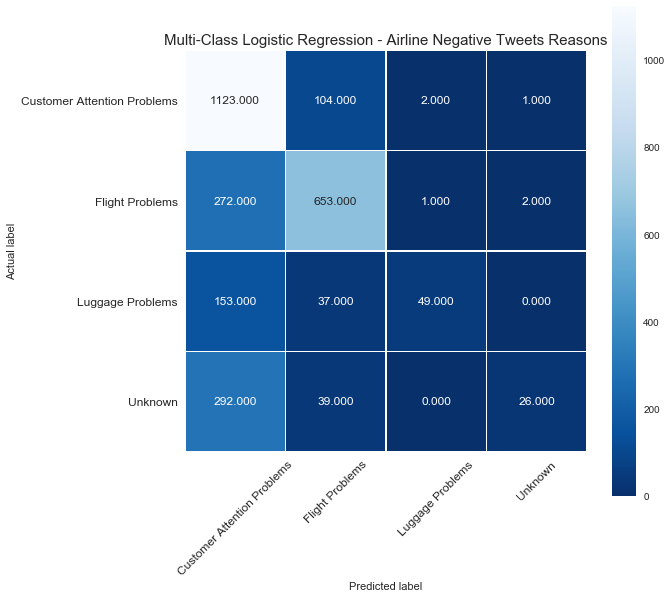

In [1475]:
#Model Results - Confusion Matrix (Airline Negative Tweets Reasons)
airN_cm = metrics.confusion_matrix(airN_y_test, airN_y_pred)
airN_score = accuracy_score(airN_y_test, airN_y_pred)

plt.figure(figsize=(9,9))

tick_marks = np.arange(len(df_airN.reason_category.unique()))
plt.xticks(tick_marks,df_airN.reason_category.unique(), rotation=45, fontsize=12)
plt.yticks(tick_marks, df_airN.reason_category.unique(), fontsize=12)


sns.heatmap(airN_cm, annot=True, fmt=".3f", linewidths=.5, 
            square = True, cmap = 'Blues_r', xticklabels= ["Customer Attention Problems", "Flight Problems", "Luggage Problems", "Unknown"], 
            yticklabels=["Customer Attention Problems", "Flight Problems", "Luggage Problems", "Unknown"]);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = "Multi-Class Logistic Regression - Airline Negative Tweets Reasons"
plt.title(all_sample_title, size = 15);

### Naive Bayes Classifier Model - Initialize (BONUS)

In [1476]:
#Initialize and Fit Model to Negative Airline Tweet Data
NBclf = MultinomialNB()
NBclf.fit(airN_X_train_tfidf, airN_y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Naive-Bayes Classifier Model - Airline Negative Tweets Reason Prediction (BONUS)

In [1477]:
#Predict Airline Negative Tweets Reason Category
airN_y_pred_NB = NBclf.predict(airN_X_test_tfidf)

#Model Results - Report (Airline Negative Tweets Reasons)
print("---Test Set Results---")
print("Accuracy with NB: {}".format(accuracy_score(airN_y_test, airN_y_pred)))
print(classification_report(airN_y_test, airN_y_pred))

---Test Set Results---
Accuracy with NB: 0.6721132897603486
                             precision    recall  f1-score   support

Customer Attention Problems       0.61      0.91      0.73      1230
            Flight Problems       0.78      0.70      0.74       928
           Luggage Problems       0.94      0.21      0.34       239
                    Unknown       0.90      0.07      0.13       357

                avg / total       0.73      0.67      0.62      2754



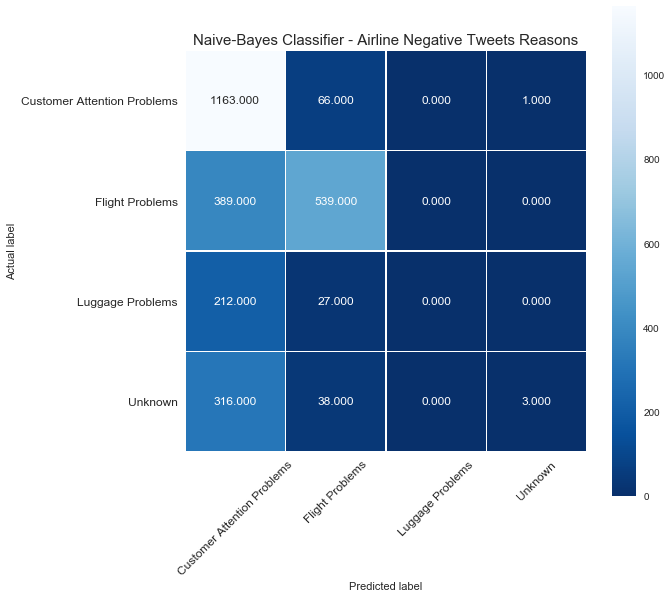

In [1478]:
#Model Results - Confusion Matrix (Airline Negative Tweets Reasons)
airN_cm_NB = metrics.confusion_matrix(airN_y_test, airN_y_pred_NB)
airN_score_NB = accuracy_score(airN_y_test, airN_y_pred_NB)

plt.figure(figsize=(9,9))
plt.xticks(tick_marks,df_airN.reason_category.unique(), rotation=45, fontsize=12)
plt.yticks(tick_marks, df_airN.reason_category.unique(), fontsize=12)
sns.heatmap(airN_cm_NB, annot=True, fmt=".3f", linewidths=.5, 
            square = True, cmap = 'Blues_r', 
            xticklabels= ["Customer Attention Problems", "Flight Problems", "Luggage Problems", "Unknown"], 
            yticklabels=["Customer Attention Problems", "Flight Problems", "Luggage Problems", "Unknown"]);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = "Naive-Bayes Classifier - Airline Negative Tweets Reasons"
plt.title(all_sample_title, size = 15);

## 6. Results & Discussions <a name="5"></a>

### “What can public opinion on Twitter tell us about the US airlines in 2015?” - an Overview 

Overall, Twitter's landscape shows an **overtly negative public opinion** on airlines.

Through regular expressions, the present analysis extracted all the Twitter handles available through the dataset's text entries. It was then possible to count the number of times each handle appeared in the whole dataset. Even if some mentions may have been missed because of misspellings or variations in their Twitter handles, this operation revealed the six most popular airlines: **Virgin Atlantic, United Airlines, Southwest Airlines, JetBlue, US Airways and American Airlines**. *(Fig. 1)*

For the next step of the analysis, an airline was considered the recipient of a tweet if it's **Twitter handle** was the first one in the entry. Tweets could then be labelled according to the main airline addressed in the text for further analysis. For example, by counting the sentiment tally for each major airline, we can see how the number of negative tweets is always higher than positive tweets. *(Fig. 3)* 

To begin to understand the reasons behind the public's take on airlines, we must look at the dataset's **negative reasons**. By visualizing each airline's tally of negative reasons we can clearly see how "Customer Service Issue" and "Late Flight" are the most common triggers for public complaints over Twitter. *(Fig. 16)* While "Customer Service Issues" as a label is still too generic, a word cloud of the tweets in said category reveal  complaints on the airlines' phone service lines - namely, long holding times, representatives hanging up, and a lack of call-back as well as responses. *(Fig. 17)* 

In general, Twitter users seem to reach the website's character limit as often as possible: even accounting for the different airlines, **average number of words per tweet** as well as the **word length of tweets** seem to be standard accross the board. *(Figs. 15, 18)*

The analysis also considered the **hashtags** employed by Twitter users. Through a process similar to the Twitter handle extraction, hashtags were isolated and counted. Note how the first, eighth and ninth most popular hashtags - "#fail", "#neveragain", "#usairwaysfail", respectively - also denote negative experiences. *(Fig. 2)*.  

Finally, our **logistic regression model** also hints at the negative public perception of airlines. The model had an easier time predicting negative labels, showcasing a **very high precision metric of 0.96** versus one of **0.47 for positive labels.** It may be possible to attribute the model's performance to the effectiveness of words as features for sentiment prediction as well as the large amount of negative vocabulary towards the airlines. 

### Public Opinion by Airline

As mentioned above, all main airlines in the dataset receive more negative tweets than positive ones. 

In terms of sheer amount, three airlines stand out for the towering count of tweets addressed to them: **United Airlines, US Airways and American Airlines**. Hence, it isn't a surprise to see these three companies as the three airlines with the highest number of negative tweets. *(Fig. 3)* Nevertheless, even after we control for tweet count, the ratio of positive-to-negative tweets for these airlines is still very low compared to the other three. *(Fig. 4)* We could then draw two, non-exclusive hypotheses: 
   1. These three airlines have particularly bad service that merits the public's negative perception.
   2. Twitter in general is used not only as a platform for negative feedback but also as a way to get the airlines' customer service crew's attention for the user's help requests.
   
Some evidence for the second hypothesis can be found in the airline Word Clouds: common shared words related to requests or inquiries include "thank", "help", "would", and "need". *(Figs. 11-16)*
   
The data also hints at a slightly more amicable public perception towards smaller airlines like **Virgin Airlines, Southwest Airlines and JetBlue**. Their respective word clouds show larger volumes of positive wording such as "great", "awesome", "love" and "cool". *(Figs. 11, 14)* Furthermore, the ratio of positive to negative tweets of these two airlines are the highest of the six; so it is likely that users are more willing to provide Virgin and JetBlue with sincere, positive commentary. 

### Multi-Class Model Results

The first, most obvious reason behind the multi-class models' lower performance is the number of classes predicted: in this case, 4 versus the 2 seen in the sentiment analysis. The added complexity is an classic cause for decreased accuracy. 

There is also the problem of the dataset's unbalanced category dispersion. That is, under the current schema, "Customer Attention Problems" and "Flight Problems" represent approximately 78% of the dataset. The overwhelming amount of records from these two categories caused the model to predict more of said label than necessary. 

Furthermore, the vocabulary of "Customer Service Issue" tweets may have also misled the model. As shown by the word clouds above, many tweets throughout the whole database are phrased as service requests - even those that deal with delayed flights or lost luggage.*(Figs. 11-16)* Hence, if the model associated this request-based vocabulary with the "Customer Service Issue" negative reason (and therefore, the "Customer Attention Problems" category), it probably mislabelled help requests associated with the other categories.

In a similar vein, overwhelmingly common vocabulary may have also been detrimental to the model. Even after implementing them as TF-IDF features, popular words with no specific association to the categories - e.g. "thank", "time", "hold" or "hours - murked the lines between each label. 

Finally, the categorization of the reasons may have also affected the performance of the model - that is, some negative reasons may overlap with other categories depending on the context. For example, "longlines" were placed in "Customer Attention Problem" under the assumption that these lines took place in the check-in counter, where users interacted directly the airline staff. Nevertheless, these lines may have also taken place during flight boarding or luggage pick-up - in those cases, the model would have likely labelled these reasons as "Flight Problems" or "Luggage Problems", respectively. A similar case could be made for "delay", which could describe negative situations both before and after flying.


### Improvements

* Logistic Regression
    * **Cross-Validation**: we could implement a cross-validation generator to split the dataset into multiple subsets that would then be used to train the model. By tracking and plotting the resulting scores from each subsample grouping, we could identify and implement the training-testing split with the highest average accuracy.

* Multi-Class Regression
    * **Category Balancing**: before running the model again, we should aim to create a new schema of categories with a more balanced tweet distribution than the current set - a schema that considered not only at types of reason, but also tweet counts per reason. This re-design, alongside sklearn.linear_model.LogisticRegression's class_weight parameter, would probably improve the model's accuracy. 